In [36]:
import torch
import cv2
from torchvision import transforms
from IPython.display import display
from utils.loss_function import SaliencyLoss
from utils.loss_function import *
from utils.data_process import preprocess_img
import numpy as np

print("All imports successful")

All imports successful


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from TranSalNet_Res import TranSalNet
model = TranSalNet()
model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth', map_location=torch.device('cpu')))

model = model.to(device) 
model.eval()

print("Model imported successfully")

Model imported successfully


torch.Size([1, 1, 288, 384])


/Users/hasinmahmood/opt/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


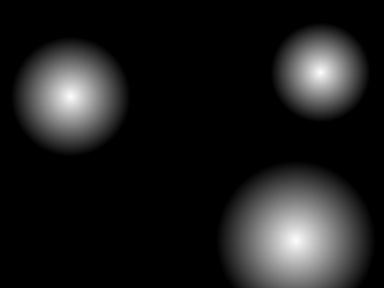

In [4]:
#TARGET TWO CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = target.shape[2] / 1.2, target.shape[3] / 1.3
cx2, cy2 = target.shape[2] /3, target.shape[2] /4.1 
cx3, cy3 = target.shape[2] /4, target.shape[2] /0.9

max_dist1, max_dist2, max_dist3 = 80, 60, 50  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)
distances2 = torch.sqrt((xx - cx2) ** 2 + (yy - cy2) ** 2)
distances3 = torch.sqrt((xx - cx3) ** 2 + (yy - cy3) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0) + torch.clamp(1 - distances2 / max_dist2, 0) + torch.clamp(1 - distances3 / max_dist3, 0)  # add the two circle values together

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)


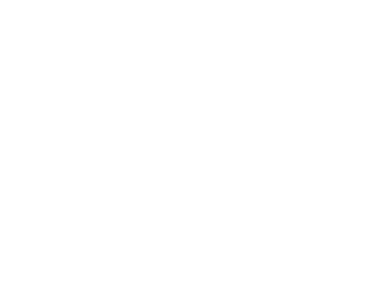

In [39]:
#TARGET CORNER
target = torch.ones(1, 1, 288, 384)

# Set the top right of the tensor to white
# target[:, :, :target.shape[2]//3, target.shape[3]//2:] = 1.0

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)

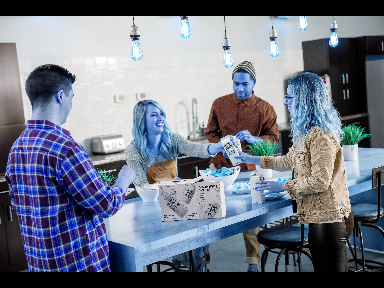

In [5]:
test_img = r'./example/1.jpg'

#padding and resizing input image into 384x288
original_image = preprocess_img(test_img)
#normalising values
original_image = np.array(original_image)/255.
original_image = np.expand_dims(np.transpose(original_image,(2,0,1)),axis=0)
original_image = torch.from_numpy(original_image)
original_image = original_image.type(torch.FloatTensor).to(device)



display(toPIL(original_image.squeeze()))

------------------------------------------
tensor([nan], grad_fn=<MeanBackward1>)
1


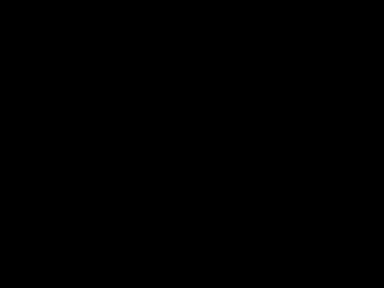

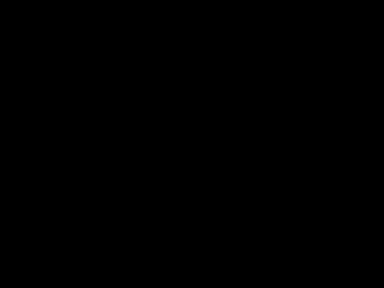

1


In [34]:
def patch_attack(patch, target_saliency,loss_target, lr):
    loss_fn=SaliencyLoss()
    loss, iterations =10, 0
    while loss_target < loss:

        print('------------------------------------------')
        
        patch = patch.clone().detach().requires_grad_(True)
        patch.retain_grad()

        out = model(patch)
        
        loss = loss_fn(out,target_saliency,loss_type='kldiv')
        loss.backward()
        
        patch = patch - (patch.grad * lr)
        
        print(loss)
        print(lr)

        if lr < 130:
            lr = lr *1.2

        iterations = iterations + 1
        
    return patch, iterations
        
        
    
final_patch, iterations = patch_attack(original_image,target,loss_target = 0.1, lr = 1)

display(toPIL(final_patch.squeeze()))

final_patch_saliency = model(final_patch)
display(toPIL(final_patch_saliency.squeeze()))

print(iterations)


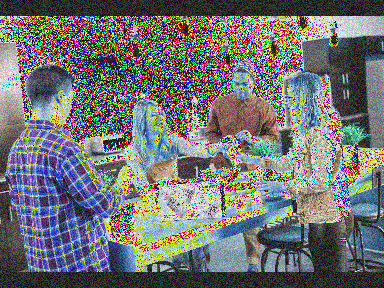

In [11]:
noisy_original_image = original_image + ((0.1**0.5)*torch.rand(1,3,288,384))
pic = toPIL(noisy_original_image.squeeze())
display(pic)

In [32]:
# Assuming a is a PyTorch tensor representing an image
testIMG = final_patch.squeeze().detach()  # Remove any dimensions with size 1

# Check the shape of the tensor and make sure it has the correct shape for an image
if len(testIMG.shape) == 2:
    testIMG = testIMG.unsqueeze(0)
if testIMG.shape[0] == 1:
    testIMG = testIMG.repeat(3, 1, 1)
if testIMG.shape[0] != 3:
    raise ValueError("Invalid number of channels in image tensor")

# Permute the dimensions to match the expected format (height, width, channels)
testIMG = testIMG.permute(1, 2, 0)

# Convert the tensor to a NumPy array and display it using OpenCV
a_numpy = testIMG.numpy()
cv2.imshow("Window", a_numpy)
cv2.waitKey(8000)
cv2.destroyAllWindows()

In [27]:
# Assuming a is a PyTorch tensor representing an image
testIMG = noisy_original_image.squeeze().detach()  # Remove any dimensions with size 1

# Check the shape of the tensor and make sure it has the correct shape for an image
if len(testIMG.shape) == 2:
    testIMG = testIMG.unsqueeze(0)
if testIMG.shape[0] == 1:
    testIMG = testIMG.repeat(3, 1, 1)
if testIMG.shape[0] != 3:
    raise ValueError("Invalid number of channels in image tensor")

# Permute the dimensions to match the expected format (height, width, channels)
testIMG = testIMG.permute(1, 2, 0)

# Convert the tensor to a NumPy array and display it using OpenCV
a_numpy = testIMG.numpy()
cv2.imshow("Window", a_numpy)
cv2.waitKey(8000)
cv2.destroyAllWindows()

In [41]:
print(loss_KLdiv(model(original_image), target))

tensor(2.5138, grad_fn=<SumBackward0>)
